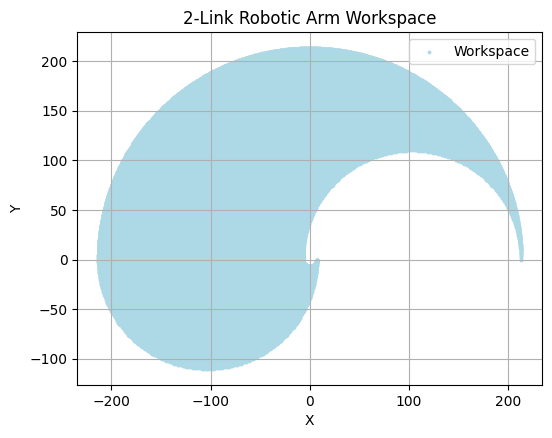

In [66]:
%reload_ext autoreload
%autoreload 2

from scara.kinematics import mk_kine_pair
import numpy as np
import matplotlib.pyplot as plt

l1 = 103
l2 = 110
forward, inverse = mk_kine_pair(l1, l2)

def draw_workspace(forward):
    """
    Draws the workspace of a 2-link robotic arm using the forward kinematics function.

    Parameters:
    forward (function): Forward kinematics function
    T1 (numpy.ndarray): Array of joint angles for the first joint
    T2 (numpy.ndarray): Array of joint angles for the second joint
    """

    # Joint ranges in radians
    theta1_range = np.linspace(0, np.pi, 200)
    theta2_range = np.linspace(0, np.pi, 200)

    # Meshgrid for all combinations
    T1, T2 = np.meshgrid(theta1_range, theta2_range)

    # Calculate the workspace points
    X, Y = forward(T1, T2)

    # Plot the workspace
    plt.figure(figsize=(6, 6))
    plt.scatter(X, Y, s=3, color='lightblue', label='Workspace')
    plt.gca().set_aspect('equal')
    plt.title("2-Link Robotic Arm Workspace")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.grid(True)
    plt.show()

# Draw the workspace using the forward function
draw_workspace(forward)

l1 = 103
l2 = 110
forward, inverse = mk_kine_pair(l1, l2)


In [81]:
l1 = 103
l2 = 110
forward, inverse = mk_kine_pair(l1, l2)

f = forward(0,0, True)
i = inverse(*f, True)
print(f, i)

converted to radians 0.0 0.0
(np.float64(-7.0), np.float64(0.0)) (np.float64(1.0177774980683254e-13), np.float64(0.0))


In [84]:
def point_inverts(forward, inverse, x_0, y_0):
    
    try:
        t1, t2 = inverse(x_0, y_0)
        x, y = forward(t1, t2)
    except ValueError:
        # If the point is unreachable, return False
        return False
    return np.isclose(x_0, x, atol=1e-2) and np.isclose(y_0, y, atol=1e-2)

def test_invertibility(forward, inverse, min_x, max_x, min_y, max_y):
    """
    Test the invertibility of the forward and inverse kinematics functions
    for a square region defined by min_x, max_x, min_y, and max_y.
    Collects all test points, sorts into success/failure, and returns stats.
    """
    x_values = np.linspace(min_x, max_x, 100)
    y_values = np.linspace(min_y, max_y, 100)

    # Collect all points to test
    points = []
    # Four corners
    points.extend([(min_x, min_y), (min_x, max_y), (max_x, min_y), (max_x, max_y)])
    # Edges
    for x in x_values:
        points.append((x, min_y))
        points.append((x, max_y))
    for y in y_values:
        points.append((min_x, y))
        points.append((max_x, y))

    s_points = []  # successful points
    f_points = []  # failed points

    for x, y in points:
        if point_inverts(forward, inverse, x, y):
            s_points.append((x, y))
        else:
            f_points.append((x, y))

    print(f"Number of test points: {len(points)}")
    print(f"Number of failed points: {len(f_points)}")

    if s_points:
        s_points_arr = np.array(s_points)
        min_x_s, max_x_s = np.min(s_points_arr[:,0]), np.max(s_points_arr[:,0])
        min_y_s, max_y_s = np.min(s_points_arr[:,1]), np.max(s_points_arr[:,1])
        print(f"Successful region: x=[{min_x_s}, {max_x_s}], y=[{min_y_s}, {max_y_s}]")
        return min_x_s, max_x_s, min_y_s, max_y_s
    else:
        print("No successful points.")
        return None

# Example usage

l1 = 103
l2 = 110
forward, inverse = mk_kine_pair(l1, l2)

test_invertibility(forward, inverse, 10, 150, 10, 100)

Number of test points: 404
Number of failed points: 0
Successful region: x=[10.0, 150.0], y=[10.0, 100.0]


(np.float64(10.0), np.float64(150.0), np.float64(10.0), np.float64(100.0))